In [16]:
from asyncio.sslproto import add_flowcontrol_defaults

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL


df = pd.read_csv('./air-passengers.csv')

df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


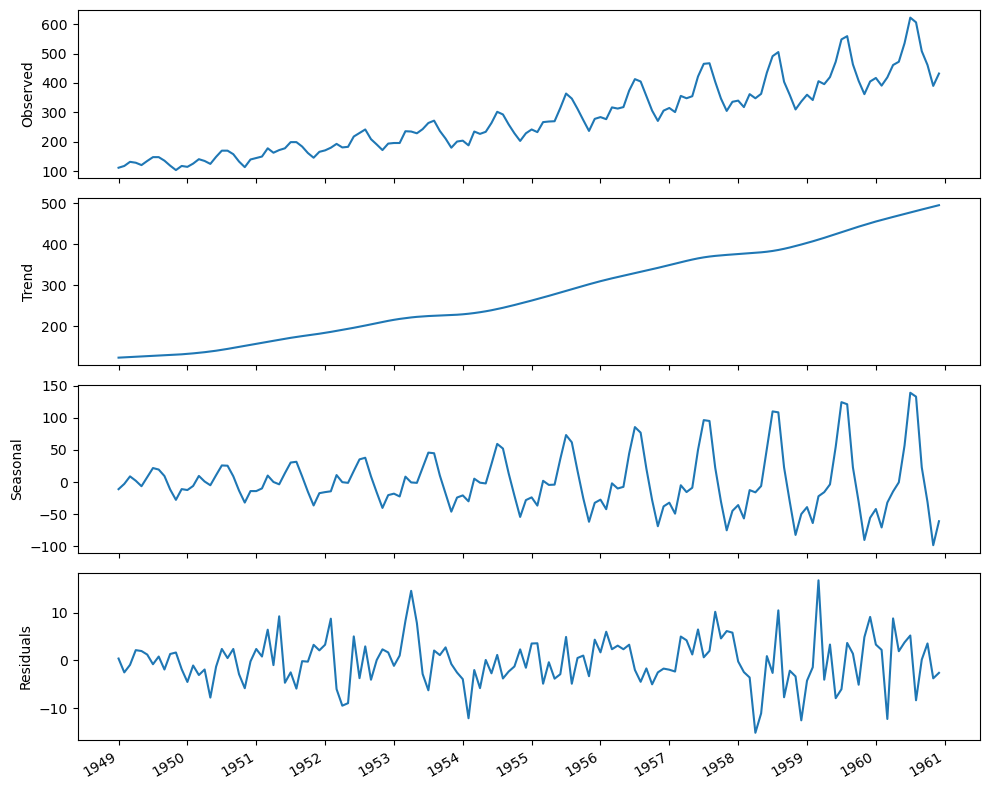

In [17]:
decomposition = STL(df['Passengers'], period=12).fit() # 분해

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
#비교를 위한 ARIMA 모델
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df['Passengers'])

print(ad_fuller_result[0])
print(ad_fuller_result[1])

0.8153688792060597
0.9918802434376411


In [19]:
#1차 차분
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(ad_fuller_result[0])
print(ad_fuller_result[1])

-2.829266824169992
0.0542132902838265


In [20]:
#2차 차분
df_diff2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff2)

print(ad_fuller_result[0])
print(ad_fuller_result[1])

-16.384231542468527
2.732891850014085e-29


In [21]:
from itertools import product
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [32]:
from typing import Union
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)

        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)','AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [37]:
train = df['Passengers'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|▎         | 5/169 [00:00<00:05, 30.02it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.860517
1,"(11, 4, 0, 0)",1019.012587
2,"(12, 0, 0, 0)",1020.386447
3,"(11, 5, 0, 0)",1020.412171
4,"(11, 1, 0, 0)",1021.016159
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


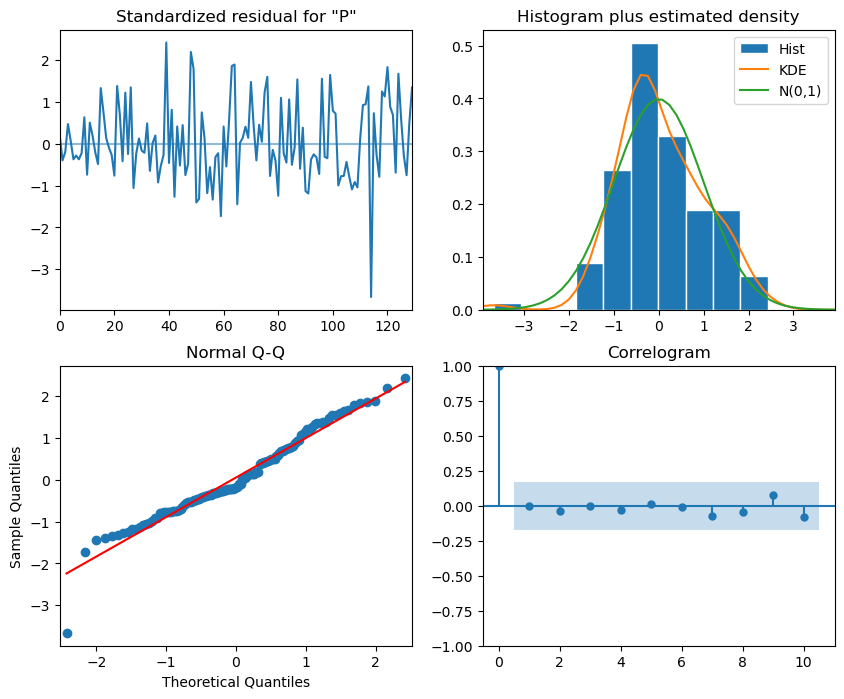

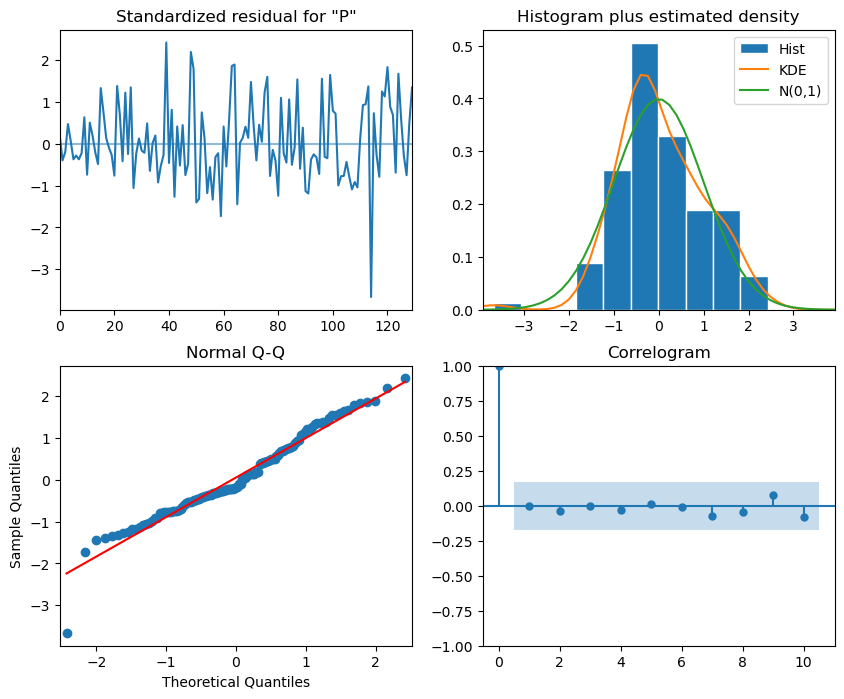

In [38]:
#ARIMA 잔차 확인
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

ARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [39]:
#융박스 테스트
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ARIMA_model_fit.resid

k = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(k)

      lb_stat  lb_pvalue
1    6.440891   0.011152
2    6.551069   0.037797
3    6.818110   0.077927
4    7.623069   0.106403
5    8.261752   0.142388
6    8.562565   0.199714
7    9.407657   0.224697
8    9.640050   0.291204
9    9.648769   0.379660
10  11.411524   0.326368


In [41]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values #단순한 계절적 예측

/tmp/ipykernel_19401/2914442530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = df['Passengers'].iloc[120:132].values #단순한 계절적 예측


In [42]:
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

/tmp/ipykernel_19401/3037488045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


In [43]:
#SARIMA
ad_fuller_result = adfuller(df['Passengers'])

print(ad_fuller_result[0])
print(ad_fuller_result[1])

0.8153688792060597
0.9918802434376411


In [44]:
#1차 차분
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(ad_fuller_result[0])
print(ad_fuller_result[1])

-2.829266824169992
0.0542132902838265


In [45]:
#계절적 차분
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(ad_fuller_result[0])
print(ad_fuller_result[1])

-17.624862360181496
3.823046855924265e-30


In [47]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMAX_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMAX_order_list, d, D, s)

  1%|          | 3/256 [00:00<00:10, 23.92it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 6/256 [00:00<00:35,  7.02it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
  4%|▍         | 10/256 [00:03<01:45,  2.32it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likel

In [48]:
SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.240764
1,"(2, 1, 2, 1)",894.040682
2,"(2, 1, 1, 3)",894.094972
3,"(1, 0, 1, 2)",894.290118
4,"(0, 1, 1, 2)",894.992151
...,...,...
248,"(0, 0, 2, 0)",906.940147
249,"(3, 2, 0, 3)",907.181875
250,"(0, 0, 3, 2)",907.471324
251,"(0, 0, 3, 0)",908.742583


/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


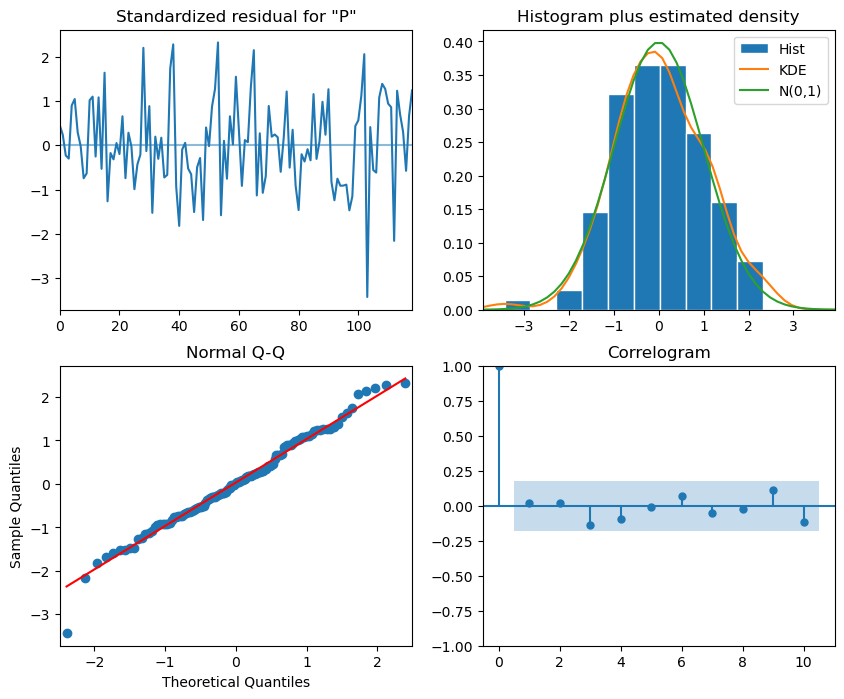

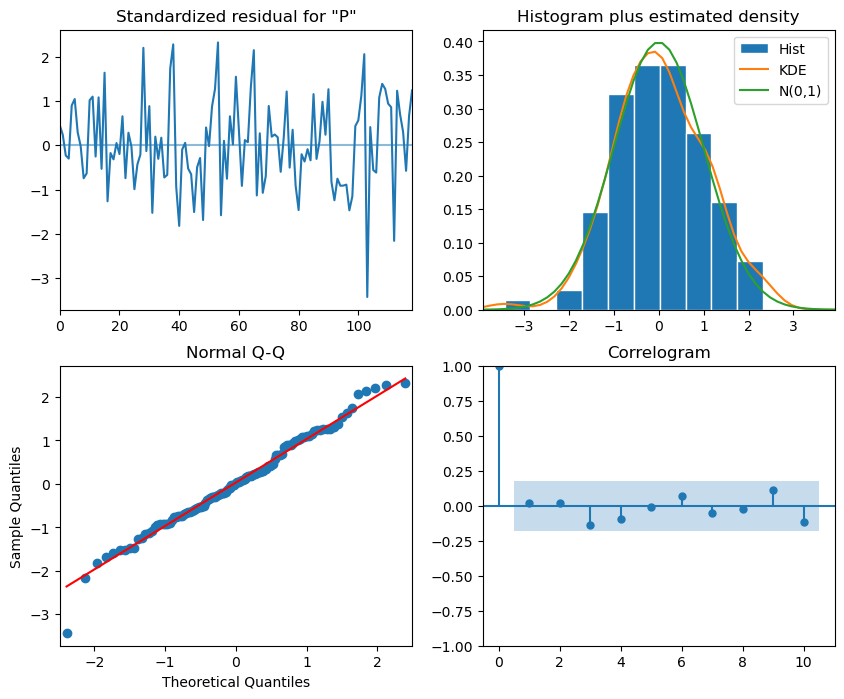

In [50]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [51]:
residuals = SARIMA_model_fit.resid

k = acorr_ljungbox(residuals, range(1, 11, 1))
print(k)

     lb_stat  lb_pvalue
1   0.004768   0.944950
2   0.747347   0.688202
3   1.024617   0.795296
4   1.228348   0.873410
5   1.437867   0.920127
6   1.713080   0.944107
7   2.309601   0.940740
8   2.719050   0.950734
9   2.735411   0.973868
10  4.968292   0.893286


In [53]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

/tmp/ipykernel_19401/379671245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


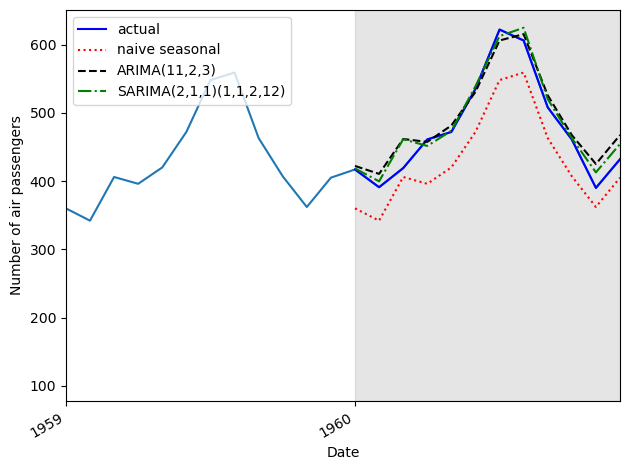

In [54]:
#각 예측 방법의 성능 비교
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()

In [59]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

9.987532920823485 3.844255434979497 2.852540776190979


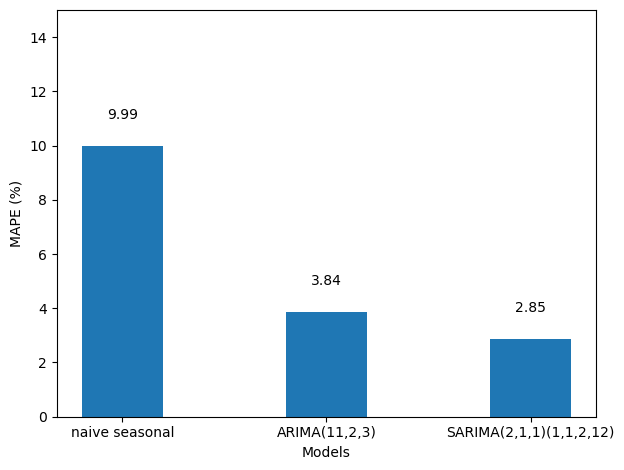

In [61]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH08_F14_peixeiro.png', dpi=300)